In [ ]:
#good factors: 3m/6m turnover rate weighted return indicates a stable reverse factor before 2017 but turned to a risk factor after 2017

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import h5py
import datetime
from scipy import stats
from math import sqrt
from scipy import optimize
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

In [2]:
#load data
industry = np.load('C:/Users/Administrator/Documents/WIND_INDCLS_MEMBER.npy')
industry_2 = np.load('C:/Users/Administrator/Documents/WIND_IDX_INDCLS2_MEMBER.npy')
PRC = np.load('C:/Users/Administrator/Documents/PRC.npy')
Turnover = np.load('C:/Users/Administrator/Documents/Turnover.npy')
Volume = np.load('C:/Users/Administrator/Documents/Volume.npy')
VWAP = np.load('C:/Users/Administrator/Documents/VWAP.npy')
HighestPrice = np.load('C:/Users/Administrator/Documents/HighestPrice.npy')
LowestPrice = np.load('C:/Users/Administrator/Documents/LowestPrice.npy')
ClosePrice = np.load('C:/Users/Administrator/Documents/ClosePrice.npy')
OpenPrice = np.load('C:/Users/Administrator/Documents/OpenPrice.npy')
dates = np.load('C:/Users/Administrator/Documents/dates.npy')
mv = np.load('C:/Users/Administrator/Documents/CAPQ0_FLOAT_A.npy')
tick = np.load('C:/Users/Administrator/Documents/ticker_names.npy')
indices = h5py.File('C:/Users/Administrator/Documents/members.hdf5','r')
td = np.load('C:/Users/Administrator/Documents/TradingDays.npy')

In [3]:
#to data frame
pd_Volume = pd.DataFrame(Volume.T,index=pd.to_datetime(dates),columns=tick)
pd_industry = pd.DataFrame(industry.T,index=pd.to_datetime(dates),columns=tick)
pd_industry_2 = pd.DataFrame(industry_2.T,index=pd.to_datetime(dates),columns=tick)
pd_PRC = pd.DataFrame(PRC.T,index=pd.to_datetime(dates),columns=tick)
pd_Turnover = pd.DataFrame(Turnover.T,index=pd.to_datetime(dates),columns=tick)
pd_VWAP = pd.DataFrame(VWAP.T,index=pd.to_datetime(dates),columns=tick)
pd_HighestPrice = pd.DataFrame(HighestPrice.T,index=pd.to_datetime(dates),columns=tick)
pd_LowestPrice = pd.DataFrame(LowestPrice.T,index=pd.to_datetime(dates),columns=tick)
pd_ClosePrice = pd.DataFrame(ClosePrice.T,index=pd.to_datetime(dates),columns=tick)
pd_OpenPrice = pd.DataFrame(OpenPrice.T,index=pd.to_datetime(dates),columns=tick)
pd_mv = pd.DataFrame(mv.T,index=pd.to_datetime(dates),columns=tick)

In [4]:
#define freqency
freq = 'm'
#aggregate
pd_VWAP = (pd_VWAP*pd_Volume).resample(freq).sum()/pd_Volume.resample(freq).sum()
pd_HighestPrice = pd_HighestPrice.resample(freq).max()
pd_LowestPrice = pd_LowestPrice.resample(freq).min()
pd_OpenPrice = pd_OpenPrice.resample(freq).first()
pd_mv = pd_mv.resample(freq).mean()
pd_Turnover = pd_Turnover.resample(freq).sum()/pd_mv*1000
pd_Volume = pd_Volume.resample(freq).sum()


In [5]:
#define tradingdays and month
start_date = '2005-01-31'
k = pd.DataFrame(dates,index=pd.to_datetime(dates)).resample('M').last()
tradingdays = pd.to_datetime(np.array(k).T[0])

tradingmonth = pd_Volume.index

In [1691]:
#get return
#pd_return_d is daily past return. it contains today's return
pd_return_d = np.log(pd_ClosePrice[1:].to_numpy()/pd_ClosePrice[:-1])
pd_return_m = np.log(pd_ClosePrice.resample(freq).last()/pd_ClosePrice.resample(freq).last().shift(1))

#past_return is monthly past return. It contains monthly return when at the end of a month
past_return = pd_return_m.copy()

#pd_return_m is the objective we want to explain/predict, it show next month's return at end of each month
pd_return_m = pd_return_m.shift(-1)

In [1692]:
#get past retrun factor
def lagplus(data,lag):
    newdata = data.iloc[(lag-1):,:].copy()
    for i in range(lag-1):
        newdata = newdata + data.shift(i)
    return(newdata)

#get cumulative lagged past return 
r_1m = past_return.copy()
r_3m = lagplus(past_return,3)
r_6m = lagplus(past_return,6)
r_12m = lagplus(past_return,12)


In [1298]:
#get turnover rate
pd_Turnover_rate = pd.DataFrame(Turnover.T/mv.T*1000,index=pd.to_datetime(dates),columns=tick)
pd_Turnover_rate 


<ipython-input-1298-45fb42db5b47>:2: RuntimeWarning: divide by zero encountered in true_divide
  pd_Turnover_rate = pd.DataFrame(Turnover.T/mv.T*1000,index=pd.to_datetime(dates),columns=tick)


,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688687,688689,688696,688698,688699,688777,688788,688819,688981,T00018
1990-12-19,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-20,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-21,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-24,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-25,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-29,0.004039,0.005340,NaN,0.013663,0.064909,0.008680,0.062074,0.004485,0.026310,0.088863,...,0.028396,0.042010,0.063652,0.044480,0.077028,0.017038,0.016977,0.078478,0.016173,NaN
2021-03-30,0.003763,0.004909,NaN,0.012899,0.040092,0.005435,0.081511,0.005362,0.012077,0.073502,...,0.018132,0.135039,0.079733,0.077807,0.121821,0.035309,0.022408,0.045133,0.010950,NaN
2021-03-31,0.003980,0.012047,NaN,0.009752,0.024205,0.004405,0.103447,0.004294,0.010534,0.044420,...,0.024205,0.065196,0.045092,0.068312,0.087332,0.030990,0.026531,0.029924,0.009592,NaN
2021-04-01,0.002801,0.005400,NaN,0.011075,0.025062,0.005801,0.203136,0.003991,0.007003,0.038883,...,0.034375,0.137528,0.047640,0.027564,0.086528,0.055643,0.015492,0.034301,0.026100,NaN


In [1693]:
#wgt_return factors
wgtr = (pd_Turnover_rate*pd_return_d).resample('M').sum()
wgt = pd_Turnover_rate.resample('M').sum()

wgt_return_1m = wgtr/wgt
wgt_return_3m = lagplus(wgtr,3)/lagplus(wgt,3)
wgt_return_6m = lagplus(wgtr,6)/lagplus(wgt,6)
wgt_return_12m = lagplus(wgtr,12)/lagplus(wgt,12)

pd_industry_2=pd_industry_2.resample('M').last()

In [1751]:
#data  normalization process

def normalization(data):
    def centrilization(x):
        y=abs(x-x.median()).median()*5
        x[x>(x.median()+y)]=x.median()+y
        x[x<(x.median()-y)]=x.median()-y
        return(x)
    data=data.apply(centrilization,axis=1)
    data=data.apply(lambda x: (x-x.mean())/x.std(),axis=1)
    return(data)


wgt_return_1m = normalization(wgt_return_1m)
wgt_return_3m = normalization(wgt_return_3m)
wgt_return_6m = normalization(wgt_return_6m)
wgt_return_12m = normalization(wgt_return_12m)
r_1m = normalization(r_1m)
r_3m = normalization(r_3m)
r_6m = normalization(r_6m)
r_12m = normalization(r_12m)

pd_return_norm = normalization(pd_return_m)

In [1696]:
#correlation stability matrix cross time
ob_t = r_12m.index[-70:-2]
co = [r_1m,r_3m,r_6m,r_12m,wgt_return_1m,wgt_return_3m,wgt_return_6m,wgt_return_12m]
correlations = pd.DataFrame(None,index=['r_1m','r_3m','r_6m','r_12m','wgt_return_1m','wgt_return_3m','wgt_return_6m','wgt_return_12m'],
                            columns=['r_1m','r_3m','r_6m','r_12m','wgt_return_1m','wgt_return_3m','wgt_return_6m','wgt_return_12m'])
selected = wgt_return_1m.loc[ob_t,:].dropna(axis=1).columns
selected = r_1m.shift(12).loc[ob_t,selected].dropna(axis=1).columns
pd_industry_2.loc[ob_t,selected][pd_industry_2.loc[ob_t,selected]==0]=None
selected = pd_industry_2.loc[ob_t,selected].dropna().columns
for i in range(len(co)-1):
    for j in range(i+1,len(co)):
        Cf = (co[i].loc[ob_t,selected]*co[j].loc[ob_t,selected]).apply(lambda x: x.sum()/len(x),axis=1)
        correlations.iloc[i,j]=Cf.mean()/Cf.std()
correlations

,r_1m,r_3m,r_6m,r_12m,wgt_return_1m,wgt_return_3m,wgt_return_6m,wgt_return_12m
r_1m,NaN,8.96388,5.54562,3.44086,6.74056,5.2498,3.22211,2.10275
r_3m,NaN,NaN,6.16059,3.96939,5.05297,6.14575,3.40043,2.25247
r_6m,NaN,NaN,NaN,5.7745,3.74645,4.37641,4.84384,2.99143
r_12m,NaN,NaN,NaN,NaN,2.6816,3.03275,3.57446,4.69707
wgt_return_1m,NaN,NaN,NaN,NaN,NaN,6.87486,3.90838,2.68613
wgt_return_3m,NaN,NaN,NaN,NaN,NaN,NaN,4.21088,2.89388
wgt_return_6m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.42398
wgt_return_12m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1732]:
#get t values, beta and IC values in for loop
#get column names
cname = ['r_1m','r_3m','r_6m','r_12m','wgt_return_1m','wgt_return_3m','wgt_return_6m','wgt_return_12m']

#get industry at the end of a month
pd_industry_2=pd_industry_2.resample('M').last()

#create empty dataframe
beta_return = pd.DataFrame(None,index=ob_t,columns=cname)
t_values = pd.DataFrame(None,index=ob_t,columns=cname)
correlations = pd.DataFrame(None,index=ob_t,columns=cname)
spcor = pd.DataFrame(None,index=ob_t,columns=cname)

#loop
for i in ob_t:
    
    #get panel data 
    panel_data = pd.DataFrame([r_1m.loc[i,selected],r_3m.loc[i,selected],r_6m.loc[i,selected],
                  r_12m.loc[i,selected],wgt_return_1m.loc[i,selected],wgt_return_3m.loc[i,selected],
                  wgt_return_6m.loc[i,selected],wgt_return_12m.loc[i,selected],pd_industry_2.loc[i,selected]],
                 index = ['r_1m','r_3m','r_6m','r_12m','wgt_return_1m','wgt_return_3m','wgt_return_6m','wgt_return_12m','industry']).T
    
    #create dummy variables
    panel_data = pd.concat([panel_data,pd.get_dummies(panel_data['industry'])],axis=1)
    panel_data.drop(['industry'],axis=1,inplace = True)


    #IC value
    #market value normalization
    f_mv = np.sqrt(pd_mv.loc[i,selected])
    f_mv = (f_mv-f_mv.mean())/f_mv.std()
    
    #IC dataframe and get dummies
    IC_data = pd.DataFrame([f_mv,pd_industry_2.loc[i,selected]],index=['market_value','industry']).T
    IC_data = pd.concat([IC_data,pd.get_dummies(IC_data['industry'])],axis=1)
    IC_data.drop(['industry'],axis=1,inplace=True)
    cor = pd.DataFrame(pd_return_m.loc[i,selected].copy())
    
    #loop for each factors 
    for j in panel_data.columns[:8]:
        
        #matrix calculation to get multiple regression estimation
        X = np.mat(IC_data.to_numpy())
        y = panel_data.loc[:,j].to_numpy()
        beta = np.dot(np.dot(np.dot(X.T,X).I,X.T),y)
        u = np.mat(y).T-np.dot(X,beta.T)
        cor.loc[:,j] = u
        
        #get beta ,u,and t-value through WLS for IC value
        X = pd.concat([panel_data.loc[:,j],panel_data.iloc[:,8:]],axis = 1)
        co = X.columns
        X = np.mat(X.to_numpy())
        y = np.mat(pd_return_m.loc[i,selected].to_numpy()).T
        w = np.mat(np.diag(np.sqrt(pd_mv.loc[i,selected])))
        beta = (X.T*w*X).I*X.T*w*y
        u = y-X*beta
        
        #estimated variation of regression
        varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
        se = np.sqrt(np.array([varbeta[k,k] for k in range(len(varbeta))]))
        beta = pd.DataFrame(beta.T,columns=co)
        
        #record estimation
        t_values.loc[i,j]=(beta/se).loc[:,j].values[0]
        beta_return.loc[i,j]=beta.loc[:,j].values[0]
    
    #2 forms of correlations(IC values)
    correlations.loc[i,:] = cor.corr().iloc[0,1:]
    spcor.loc[i,:] = cor.corr(method='spearman').iloc[0,1:]
    
    print(i)

2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-10-31 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-01-31 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-04-30 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-07-31 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2016-12-31 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-04-30 00:00:00
2017-05-31 00:00:00
2017-06-30 00:00:00
2017-07-31 00:00:00
2017-08-31 00:00:00
2017-09-30 00:00:00
2017-10-31 00:00:00
2017-11-30 00:00:00
2017-12-31 00:00:00
2018-01-31 00:00:00
2018-02-28 00:00:00
2018-03-31 00:00:00
2018-04-30 00:00:00
2018-05-31 00:00:00
2018-06-30 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-09-30 00:00:00
2018-10-31 00:00:00


KeyboardInterrupt: 

In [1756]:
#date process and combination
mydata = np.stack([r_1m,r_3m,r_6m,r_12m,wgt_return_1m,wgt_return_3m,wgt_return_6m,wgt_return_12m,pd_industry_2,pd_return_norm,pd_mv])
axis0 = ['r_1m','r_3m','r_6m','r_12m','wgt_return_1m','wgt_return_3m','wgt_return_6m','wgt_return_12m','industry','return','market value']
axis1 = r_1m.index
axis2 = tick
axis = [axis0,axis1,axis2]

def beta_test(mydata,axis,obt,indcies = None):

    axis0 = axis[0]
    axis1 = axis[1]
    axis2 = axis[2]

    #get t values, beta and IC values in for loop
    #get column names

    #create empty dataframe
    beta_return = pd.DataFrame(None,index=ob_t,columns=axis0[:-3])
    t_values = beta_return.copy()

    #loop
    for i in ob_t:
        #get panel data 
        panel_data = pd.DataFrame(mydata[:,np.where(axis1 == i)[0][0],:],
                     index = axis0,columns=tick).T
        
        if indcies!= None:
            selected = indices[choice][datetime.datetime.strftime(ob_t[0],'%Y%m%d')][:].astype('U6')
            panel_data = panel_data.loc[selected,:]

        #create dummy variables
        panel_data.dropna(axis=0,inplace=True)

        #separate mv and return
        re = panel_data['return']
        mv = panel_data['market value']

        #get dummies and drop others
        panel_data = pd.concat([panel_data,pd.get_dummies(panel_data['industry'])],axis=1)
        panel_data.drop(['industry','return','market value'],axis=1,inplace = True)

        selected = panel_data.index

        #loop for each factors 
        for j in axis0[:-3]:

            #get beta ,u,and t-value through WLS 
            X = pd.concat([panel_data.loc[:,j],panel_data.iloc[:,len(axis0)-3:]],axis = 1)
            co = X.columns
            X = np.mat(X.to_numpy())
            y = np.mat(re[selected].to_numpy()).T
            w = np.mat(np.diag(np.sqrt(mv[selected])))
            beta = (X.T*w*X).I*X.T*w*y
            u = y-X*beta

            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            beta = pd.DataFrame(beta.T,columns=co)

            #record estimation
            t_values.loc[i,j]=(beta/se).loc[:,j].values[0]
            beta_return.loc[i,j]=beta.loc[:,j].values[0]

        print(i)
    return([t_values,beta_return])

In [1757]:
t_values = beta_test(mydata,axis,ob_t)[0]

2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-10-31 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-01-31 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-04-30 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-07-31 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2016-12-31 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-04-30 00:00:00
2017-05-31 00:00:00
2017-06-30 00:00:00
2017-07-31 00:00:00
2017-08-31 00:00:00
2017-09-30 00:00:00
2017-10-31 00:00:00
2017-11-30 00:00:00
2017-12-31 00:00:00
2018-01-31 00:00:00
2018-02-28 00:00:00
2018-03-31 00:00:00
2018-04-30 00:00:00
2018-05-31 00:00:00
2018-06-30 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-09-30 00:00:00
2018-10-31 00:00:00
2018-11-30 00:00:00
2018-12-31 00:00:00
2019-01-31 00:00:00
2019-02-28 00:00:00
2019-03-31 00:00:00
2019-04-30 00:00:00
2019-05-31 00:00:00
2019-06-30 00:00:00
2019-07-31 00:00:00
2019-08-31 00:00:00


                    mean    |mean|       std  |mean|/std   |t|>2/t     t<0/t
r_1m           -1.704066  4.769347  5.662090    0.842330  0.691176  0.617647
r_3m           -1.575306  5.255904  6.066089    0.866440  0.764706  0.617647
r_6m           -0.993820  5.817373  6.560410    0.886739  0.852941  0.558824
r_12m          -0.399401  6.291690  7.124018    0.883166  0.867647  0.529412
wgt_return_1m   2.850315  4.885523  5.111602    0.955771  0.764706  0.279412
wgt_return_3m   2.518432  4.991345  5.458954    0.914341  0.735294  0.323529
wgt_return_6m   1.849858  5.405034  6.143421    0.879809  0.794118  0.411765
wgt_return_12m  1.093119  5.724788  6.521306    0.877859  0.867647  0.470588


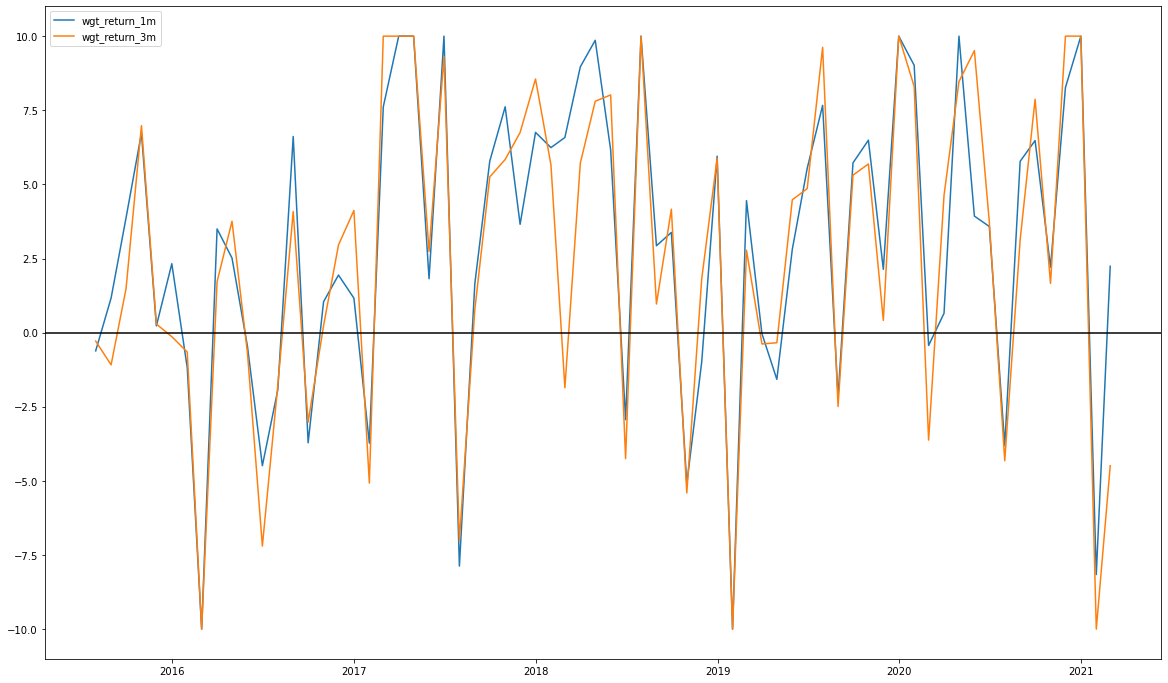

In [1759]:
#statistics desctiption
def describe(t,n=2,limit=10):
    t[t>limit]=limit
    t[t<-limit]=-limit
    des = pd.DataFrame(None,index = t.columns,columns=['mean','|mean|','std','|mean|/std','|t|>2/t','t<0/t'])
    des.loc[:,'mean']=t.mean()
    des.loc[:,'|mean|']=abs(t).mean()
    des.loc[:,'std']=t.std()
    des.loc[:,'|mean|/std']=abs(t).mean()/t.std()
    des.loc[:,'|t|>2/t']=t[abs(t)>2].count()/t.count()
    des.loc[:,'t<0/t']=t[t<0].count()/t.count()
    print(des)
    plt.figure(figsize=(20,12))
    best2 = (des.index[np.argsort(-des.loc[:,'|mean|/std'])[:n]])
    for i in best2:
        plt.plot(t.loc[:,i],label=i)
    plt.axhline(y=0,c="black")
    plt.legend()
describe(t_values)

C:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


acf
 [ 1.         -0.10329269 -0.1466565   0.08323366 -0.05780964  0.05208714
  0.00181669  0.20434871 -0.14072153 -0.24381657  0.04784328  0.09449774
 -0.04863451 -0.15734318 -0.003429   -0.12088177] 
pacf
 [ 1.         -0.10642278 -0.16906311  0.05613165 -0.07761542  0.07236538
 -0.01231915  0.30509732 -0.16856653 -0.29515903 -0.12807446  0.15388823
 -0.07286778 -0.34084485 -0.18915696 -0.21418156]


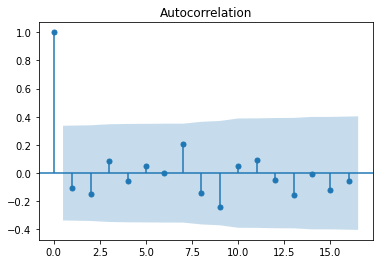

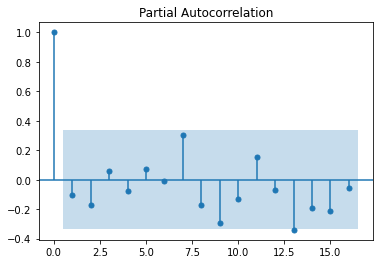

In [1760]:
#autocorrelation examination

def autocor(t,lag=10):
    acf=smt.stattools.acf(t,nlags=15)
    pacf=smt.stattools.pacf(t,nlags=15)
    print('acf\n',acf,'\npacf\n',pacf)

    plot_acf(t)
    plot_pacf(t)
autocor(t_values.loc[:,'wgt_return_3m'][round(len(t_values)/2):])

In [1865]:
#construct a grouped backtest framework, inputs are factors, next term return, m groups and observed time.
def classified_backtest (df,re,m,obt):
    
    #create an empty dataframe for return of groups
    classified_return = pd.DataFrame(None,index=ob_t,columns=list(range(m)))
    
    for d in ob_t:    
        holdings = pd.DataFrame(0,index=list(range(m)),columns=selected)
        #get industry and counts numbers
        ind = pd_industry_2.loc[d,selected].value_counts()

        #get intervals
        path = ind/m

        for i in path.index:
            stock = selected[pd_industry_2.loc[d,selected]==i]
            
            #get intervals 
            mypath = np.arange(len(stock),step = path[i])
            mypath = np.append(mypath,len(stock))
            order = np.argsort(df.loc[d,stock])[::-1]

            for p in range(m):
                #get order and location
                own = order.index[math.ceil(mypath[p]):math.floor(mypath[p+1])]
                xiao = order.index[min(math.floor(mypath[p+1]),int(mypath[m])-1)]
                qian = order.index[math.floor(mypath[p])]

                #give weight
                weight = len(selected)/m

                #fill weight of selected securities into groups
                holdings.loc[p,xiao] = min(mypath[p+1]-mypath[p],mypath[p+1]-math.floor(mypath[p+1]))/weight
                holdings.loc[p,qian] = min(mypath[p+1]-mypath[p],math.ceil(mypath[p])-mypath[p])/weight
                holdings.loc[p,own] = 1/weight  
                
        #get return for different groups
        classified_return.loc[d,:]=(holdings*re.loc[d,selected]).sum(axis=1)
        
        print(d)
        
    return(classified_return)

In [1866]:
#test for momentum
classified_return_r1m=classified_backtest(r_1m,pd_return_m,5,ob_t)
classified_return_r3m=classified_backtest(r_3m,pd_return_m,5,ob_t)
classified_return_r6m=classified_backtest(r_6m,pd_return_m,5,ob_t)
classified_return_r12m=classified_backtest(r_12m,pd_return_m,5,ob_t)
classified_return_wgt_1m=classified_backtest(wgt_return_1m,pd_return_m,5,ob_t)
classified_return_wgt_3m=classified_backtest(wgt_return_3m,pd_return_m,5,ob_t)
classified_return_wgt_6m=classified_backtest(wgt_return_6m,pd_return_m,5,ob_t)
classified_return_wgt_12m=classified_backtest(wgt_return_12m,pd_return_m,5,ob_t)

2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-10-31 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-01-31 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-04-30 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-07-31 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2016-12-31 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-04-30 00:00:00
2017-05-31 00:00:00
2017-06-30 00:00:00
2017-07-31 00:00:00
2017-08-31 00:00:00
2017-09-30 00:00:00
2017-10-31 00:00:00
2017-11-30 00:00:00
2017-12-31 00:00:00
2018-01-31 00:00:00
2018-02-28 00:00:00
2018-03-31 00:00:00
2018-04-30 00:00:00
2018-05-31 00:00:00
2018-06-30 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-09-30 00:00:00
2018-10-31 00:00:00
2018-11-30 00:00:00
2018-12-31 00:00:00
2019-01-31 00:00:00
2019-02-28 00:00:00
2019-03-31 00:00:00
2019-04-30 00:00:00
2019-05-31 00:00:00
2019-06-30 00:00:00
2019-07-31 00:00:00
2019-08-31 00:00:00


2015-09-30 00:00:00
2015-10-31 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-01-31 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-04-30 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-07-31 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2016-12-31 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-04-30 00:00:00
2017-05-31 00:00:00
2017-06-30 00:00:00
2017-07-31 00:00:00
2017-08-31 00:00:00
2017-09-30 00:00:00
2017-10-31 00:00:00
2017-11-30 00:00:00
2017-12-31 00:00:00
2018-01-31 00:00:00
2018-02-28 00:00:00
2018-03-31 00:00:00
2018-04-30 00:00:00
2018-05-31 00:00:00
2018-06-30 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-09-30 00:00:00
2018-10-31 00:00:00
2018-11-30 00:00:00
2018-12-31 00:00:00
2019-01-31 00:00:00
2019-02-28 00:00:00
2019-03-31 00:00:00
2019-04-30 00:00:00
2019-05-31 00:00:00
2019-06-30 00:00:00
2019-07-31 00:00:00
2019-08-31 00:00:00
2019-09-30 00:00:00
2019-10-31 00:00:00


In [2320]:
def classified_backtest (df,re,m,obt):
    
    def fill_by_d(d):
        holdings = pd.DataFrame(0,index=list(range(m)),columns=selected)
        #get industry and counts numbers
        selected = pd_industry_2.loc[d,:][pd_industry_2.loc[d,:]!=0].index
        ind = pd_industry_2.loc[d,selected].value_counts()

        #get intervals
        path = ind/m

        for i in path.index:
            stock = selected[pd_industry_2.loc[d,selected]==i]

            #get intervals 
            mypath = np.arange(len(stock),step = path[i])
            mypath = np.append(mypath,len(stock))
            order = np.argsort(df.loc[d,stock])[::-1]

            for p in range(m):
                own = order.index[math.ceil(mypath[p]):math.floor(mypath[p+1])]
                xiao = order.index[min(math.floor(mypath[p+1]),int(mypath[m])-1)]
                qian = order.index[math.floor(mypath[p])]

                #give weight
                weight = len(selected)/m

                #fill weight of selected securities into groups
                holdings.loc[p,xiao] = min(mypath[p+1]-mypath[p],mypath[p+1]-math.floor(mypath[p+1]))/weight
                holdings.loc[p,qian] = min(mypath[p+1]-mypath[p],math.ceil(mypath[p])-mypath[p])/weight
                holdings.loc[p,own] = 1/weight  
                
                
        return((holdings*re.loc[d,selected]).sum(axis=1))

    #create an empty dataframe for return of groups
    classified_return = pd.DataFrame(None,index=ob_t,columns=list(range(m)))
    
    holdings = map(fill_by_d,ob_t)
                
    #get return for different groups
    classified_return.loc[d,:]=(holdings*re.loc[d,selected]).sum(axis=1)
        
    print(d)
        
    return(classified_return)

classified_return_r3m_test2=classified_backtest(r_3m,pd_return_m,5,ob_t)

IndentationError: unexpected indent (<ipython-input-2320-b39202109c74>, line 42)

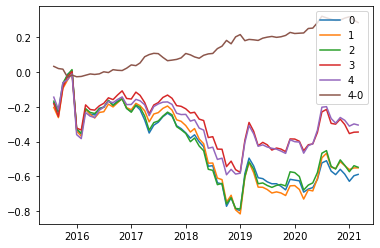

In [1914]:
#plot 
for i in range(5):
    plt.plot(classified_return_r3m_test2.iloc[:,i].cumsum(),label=i)
plt.plot((classified_return_r3m_test2.iloc[:,4]-classified_return_r3m_test2.iloc[:,0]).cumsum(),label='4-0')
plt.legend()

{'mean': 0.013961351215886314, 'median': 0.009076877494623825, 'std': 0.09874563921267776, 'skewness': -0.1688253322990267, 'kurtosis': 1.0208411224943665}


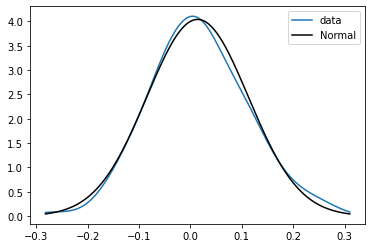

In [1410]:
#statistics description
def statistics(close):
    
    mc = np.mean(close)
    stdc = np.std(close)
    print({'mean':mc,'median':np.median(close),'std':stdc,'skewness':stats.skew(close),'kurtosis':stats.kurtosis(close)})
    
    #distribution plot
    x = np.linspace(mc-3*stdc,mc+3*stdc,200)
    y = stats.norm.pdf(x,mc,stdc)
    kde = stats.gaussian_kde(close)
    plt.plot(x,kde(x),label='data')
    plt.plot(x,y,color='black',label='Normal')
    plt.legend()
    plt.show()
    
statistics(past_return.iloc[-150:-2,0])

In [1782]:
#tech
order

688208    291
688188    175
688181      1
688159    161
688138     80
         ... 
000050    350
000045    116
000034     60
000032    209
000021    232
Name: 2021-01-31 00:00:00, Length: 357, dtype: int64

In [2328]:
#construct a grouped backtest framework, inputs are factors, next term return, m groups and observed time.
def classified_backtest_index (df,re,m,obt,choice=None):
    
    #create an empty dataframe for return of groups
    classified_return = pd.DataFrame(None,index=ob_t,columns=list(range(m)))
    
    for d in ob_t:
        if choice == None:
            selected = re.loc[d,:].dropna().index()
        else:
            selected = indices[choice][timming.loc[d][0]][:].astype('U6')
        
        holdings = pd.DataFrame(0,index=list(range(m)),columns=selected)

        #get industry and counts numbers
        ind = pd_industry_2.loc[d,selected].value_counts()

        #get intervals
        path = ind/m

        for i in path.index:
            stock = selected[pd_industry_2.loc[d,selected]==i]
            
            #get intervals 
            mypath = np.arange(len(stock),step = path[i])
            mypath = np.append(mypath,len(stock))
            order = np.argsort(df.loc[d,stock])[::-1]

            for p in range(m):
                #get order and location
                own = order.index[math.ceil(mypath[p]):math.floor(mypath[p+1])]
                xiao = order.index[min(math.floor(mypath[p+1]),int(mypath[m])-1)]
                qian = order.index[math.floor(mypath[p])]

                #give weight
                weight = len(selected)/m

                #fill weight of selected securities into groups
                holdings.loc[p,xiao] = min(mypath[p+1]-mypath[p],mypath[p+1]-math.floor(mypath[p+1]))/weight
                holdings.loc[p,qian] = min(mypath[p+1]-mypath[p],math.ceil(mypath[p])-mypath[p])/weight
                holdings.loc[p,own] = 1/weight  
                
        #get return for different groups
        classified_return.loc[d,:]=(holdings*re.loc[d,selected]).sum(axis=1)
        
        print(d)
        
    return(classified_return)

In [1912]:
classified_return_r3m_test2=classified_backtest_index(r_3m,pd_return_m,5,ob_t,'000905')

2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-10-31 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-01-31 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-04-30 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-07-31 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2016-12-31 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-04-30 00:00:00
2017-05-31 00:00:00
2017-06-30 00:00:00
2017-07-31 00:00:00
2017-08-31 00:00:00
2017-09-30 00:00:00
2017-10-31 00:00:00
2017-11-30 00:00:00
2017-12-31 00:00:00
2018-01-31 00:00:00
2018-02-28 00:00:00
2018-03-31 00:00:00
2018-04-30 00:00:00
2018-05-31 00:00:00
2018-06-30 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-09-30 00:00:00
2018-10-31 00:00:00
2018-11-30 00:00:00
2018-12-31 00:00:00
2019-01-31 00:00:00
2019-02-28 00:00:00
2019-03-31 00:00:00
2019-04-30 00:00:00
2019-05-31 00:00:00
2019-06-30 00:00:00
2019-07-31 00:00:00
2019-08-31 00:00:00


In [2054]:
pd_VWAP = pd.DataFrame(VWAP.T,index=pd.to_datetime(dates),columns=tick)


day_index = pd_VWAP.loc[:,'000905'][4000:-400].index

#for days with intervals
(day_index[:-1]!=(day_index-datetime.timedelta(days = 1))[1:]).astype('int')

array([0, 0, 0, ..., 0, 0, 0])

In [2055]:
#test several technique factors
buy = pd.DataFrame((day_index[:-1]!=(day_index-datetime.timedelta(days = 1))[1:]).astype('int'),index=day_index[:-1]).shift(-1)
sell = pd.DataFrame((day_index[:-1]!=(day_index-datetime.timedelta(days = 1))[1:]).astype('int'),index=day_index[1:])

In [2056]:
buydays = buy.index
selldays = sell.index

In [2057]:
pd_ClosePrice.loc[selldays,'000905'].tail(10)

2019-07-26    20.102391
2019-07-29    19.945952
2019-07-30    19.972025
2019-07-31    19.763440
2019-08-01    19.476636
2019-08-02    18.850880
2019-08-05    18.746588
2019-08-06    18.094759
2019-08-07    18.225125
2019-08-08    18.225125
Name: 000905, dtype: float64

In [2059]:
(pd.DataFrame(sell.to_numpy().T[0]*pd_ClosePrice.loc[selldays,'000905'].to_numpy(),index=selldays)-pd.DataFrame(buy.to_numpy().T[0]*pd_ClosePrice.loc[buydays,'000905'].to_numpy(),index=buydays)).dropna(axis=0).sum()

0   -9.037883
dtype: float64

In [2024]:
statis = pd.concat([pd.DataFrame(pd_return_d.loc[:,'000905'][4000:]),buy-sell],axis=1).dropna(axis=0)

In [2130]:
lag_days_1 = (day_index+datetime.timedelta(days = 1))[:-3]
lag_days_2 = (day_index+datetime.timedelta(days = 2))[:-3]
lag_days_3 = (day_index+datetime.timedelta(days = 3))[:-3]

In [2147]:
risk_averse = []
i_record = []
after_risk = []
for i in range(len(day_index)-3):
    if lag_days_1[i] not in day_index and lag_days_2[i] not in day_index and lag_days_3[i] not in day_index:
        risk_averse.append(day_index[i])
        after_risk.append(day_index[i+1])
        i_record.append(i)

In [2192]:
def t_test(a,b):
    t_averse=(pd_return_d.loc[a,:].mean()/pd_return_d.loc[a,:].std()*sqrt(len(a)))
    t_after=(pd_return_d.loc[b,:].mean()/pd_return_d.loc[b,:].std()*sqrt(len(b)))
    risk_pool = tick[(t_averse<-2) & (t_after>2)]
    print('before mean\n',pd_return_d.loc[a,risk_pool].mean())
    return(risk_pool)
pool = t_test(risk_averse,after_risk)

before mean
 001965   -0.014746
001979   -0.009212
002673   -0.009077
002739   -0.008468
002757   -0.011976
            ...   
603880   -0.009193
603885   -0.010091
603897   -0.025150
603933   -0.012714
603987   -0.008170
Length: 206, dtype: float64


001965    1.426156e+10
001979    1.000196e+11
002673    3.148763e+10
002739    3.672389e+10
002757    3.575096e+09
              ...     
603880    2.252785e+09
603885    2.635437e+10
603897    9.459512e+08
603933    1.949687e+09
603987    8.789858e+09
Name: 2021-03-31 00:00:00, Length: 206, dtype: float64

In [2101]:
(day_index-datetime.timedelta(days = 3))[(3):(6+5)]

DatetimeIndex(['2007-04-09', '2007-04-10', '2007-04-13', '2007-04-14',
               '2007-04-15', '2007-04-16', '2007-04-17', '2007-04-20'],
              dtype='datetime64[ns]', freq=None)

In [2103]:
(day_index[(3+i):(6+i)]-datetime.timedelta(days = 3))

DatetimeIndex(['2007-04-14', '2007-04-15', '2007-04-16'], dtype='datetime64[ns]', freq=None)

001979    0.123634
002673    0.231315
002739    0.066766
002757    0.070101
002788    0.132624
002790    0.103163
002797    0.325770
300144    0.158992
300417    0.035550
300482    0.120139
300488    0.262436
600936    0.088324
601155    0.323468
601211    0.148249
601555    0.116238
603101    0.157791
603116    0.127211
603198    0.173133
603223    0.083716
603696    0.185489
603885    0.221263
dtype: float64

In [2237]:
day_2_return = (pd_return_d+pd_return_d.shift(1)).loc[after_risk,:]

In [2231]:
ready_to_buy = (day_2_return.mean()/day_2_return.std()*sqrt(80))>2
(day_2_return.loc[:,ready_to_buy].mean(axis=1)>0).sum()

60

In [2236]:
for i in after_risk:
    pd_mv.loc[i,:]

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688687,688689,688696,688698,688699,688777,688788,688819,688981,T00018
2007-05-08,0.054736,0.190767,NaN,-0.011050,4.928350e-02,0.095175,0.098394,1.734723e-17,0.097904,0.026575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-08,0.021527,0.095009,NaN,-0.007483,2.633381e-02,0.055608,-0.001354,-2.032770e-02,0.056202,0.048790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,-0.032919,-0.012210,NaN,0.069796,4.939276e-02,0.013673,0.077995,7.226045e-03,-0.010749,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-13,-0.008346,-0.035357,NaN,-0.001098,-5.578815e-03,0.009200,-0.002821,-1.705071e-02,0.008487,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-07,0.013915,0.064791,NaN,0.051293,6.043174e-02,0.095269,0.023108,4.866517e-02,0.000000,-0.102828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-02,-0.010718,0.010441,NaN,0.013631,5.421011e-17,-0.005808,-0.028951,-1.293679e-02,-0.016375,0.006116,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-11,-0.000893,-0.010167,NaN,0.049768,2.000067e-02,0.044452,0.045120,2.898754e-02,0.037041,0.048319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-08,-0.003614,0.038361,NaN,0.000000,-7.585371e-03,-0.004216,-0.015979,-4.032264e-03,-0.045527,0.018446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-06,-0.067189,-0.031659,NaN,-0.030524,-4.019088e-02,-0.067823,-0.030623,-7.249550e-02,-0.039609,-0.060259,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2248]:
pd_mv.loc[after_risk[1],:]

000001    NaN
000002    NaN
000003    NaN
000004    NaN
000005    NaN
         ... 
688777    NaN
688788    NaN
688819    NaN
688981    NaN
T00018    NaN
Name: 2007-10-08 00:00:00, Length: 4368, dtype: object

In [2249]:
pd_mv

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688687,688689,688696,688698,688699,688777,688788,688819,688981,T00018
1990-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2258]:
pd_mv = pd.DataFrame(mv,index=tick,columns=pd.to_datetime(dates)).T
pd_mv = np.log(np.sqrt(pd_mv))

In [2317]:
residuals = pd.DataFrame(None,index=after_risk,columns=tick)
for i in range(len(risk_averse)):
    pd_industry_2 = pd.DataFrame(industry_2.T,index=pd.to_datetime(dates),columns=tick)
    panel_data = pd.DataFrame((pd_mv.loc[risk_averse[i],:],pd_industry_2.loc[risk_averse[i],:]),index=['mv','industry'],columns=tick).T
    panel_data.dropna(axis=0,inplace = True)
    
    panel_data = pd.concat([panel_data,pd.get_dummies(panel_data['industry'])],axis=1)
    panel_data.drop(['industry'],axis=1,inplace = True)

    selected = panel_data.index
    y = np.mat(day_2_return.loc[after_risk[i],selected]).T


    #get beta ,u,and t-value through WLS 
    X = panel_data
    co = X.columns
    X = np.mat(X.to_numpy())
    beta = (X.T*X).I*X.T*y
    u = y-X*beta
    residuals.loc[after_risk[i],selected]=np.array(u.T)[0]
    

In [2318]:
residuals

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688687,688689,688696,688698,688699,688777,688788,688819,688981,T00018
2007-05-08,-0.0105608,0.133362,NaN,-0.0431835,-0.0130036,0.0328575,0.0664407,-0.0398797,0.058539,-0.0132534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-08,-0.0288462,0.0444273,NaN,-0.0163915,-0.013124,0.0159991,0.0244695,-0.0273849,0.0485659,0.0416996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,-0.022255,0.00549518,NaN,0.0239003,-0.00130985,-0.0368069,0.0147544,-0.040425,-0.054834,-0.0474798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-13,0.00945138,0.0053304,NaN,-0.0312978,-0.0133992,0.00168655,-0.00876825,-0.0309627,-0.00314656,-0.0137786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-07,-0.00659305,0.0101742,NaN,-0.0283543,-0.0184345,0.0165093,-0.0503888,-0.0287325,-0.0760411,-0.18013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-02,-0.00765078,0.0243462,NaN,0.0440616,0.0127053,0.00129431,-0.0219845,-0.0135042,-0.0169665,0.00529898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-11,-0.0114399,-0.0325175,NaN,-0.000473918,-0.0208944,0.0121478,0.012607,-0.0114139,-0.00338219,0.00761355,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-08,0.0061072,0.0288991,NaN,-0.0174695,-0.0175063,-0.0120089,-0.0237315,-0.00402155,-0.0455291,0.0185168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-06,-0.0513911,0.0228536,NaN,0.0210966,0.0285689,-0.0145129,0.0226591,-0.00542135,0.0274736,0.00677359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


KeyError: Timestamp('2015-07-31 00:00:00', freq='M')

In [2334]:
datetime.datetime.strftime(ob_t[0],'%Y%m%d')

C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


'20150731'

In [2376]:
EPS = np.load('C:/Users/Administrator/Documents/FIQ0_S_FA_EPS_BASIC.npy')
fd_dates = np.load('C:/Users/Administrator/Documents/EPS_dates.npy')
fd_tick = np.load('C:/Users/Administrator/Documents/EPS_ticker_names.npy')
BPS = np.load('C:/Users/Administrator/Documents/FIQ0_S_FA_BPS.npy')
index_close = np.load('C:/Users/Administrator/Documents/index_ClosePrice.npy')
index_tick = np.load('C:/Users/Administrator/Documents/index_ticker_names.npy')

In [2368]:
pd_eps = pd.DataFrame(EPS.T,index = pd.to_datetime(fd_dates),columns=fd_tick)
pd_bps = pd.DataFrame(BPS.T,index = pd.to_datetime(fd_dates),columns=fd_tick)

In [2378]:
index_close = pd.DataFrame(index_close.T,index = pd.to_datetime(fd_dates),columns=index_tick)

1990-12-19          NaN
1990-12-20          NaN
1990-12-21          NaN
1990-12-24          NaN
1990-12-25          NaN
                ...    
2021-04-20    6428.5411
2021-04-21    6420.2587
2021-04-22    6445.4657
2021-04-23    6462.7558
2021-04-26    6442.6451
Name: 000905, Length: 7419, dtype: float64

In [2373]:
pd_eps = pd_eps.loc[pd.to_datetime(dates),tick]
pd_bps = pd_bps.loc[pd.to_datetime(dates),tick]
adj_f =  np.load('C:/Users/Administrator/Documents/AdjFactor.npy')
pd_ep = pd_eps/pd_ClosePrice*adj_f.T
pd_bp = pd_bps/pd_ClosePrice*adj_f.T

In [2379]:
#Fama—French 3 factors model
#get fama alpha
beta_return = pd.DataFrame(None,index=ob_t,columns=cname)
t_values = pd.DataFrame(None,index=ob_t,columns=cname)
correlations = pd.DataFrame(None,index=ob_t,columns=cname)
spcor = pd.DataFrame(None,index=ob_t,columns=cname)

#loop
for i in ob_t:
    HML = 
    #get panel data 
    panel_data = pd.DataFrame([pd_bp,],
                 index = []).T
    
    #create dummy variables
    panel_data = pd.concat([panel_data,pd.get_dummies(panel_data['industry'])],axis=1)
    panel_data.drop(['industry'],axis=1,inplace = True)


    #IC value
    #market value normalization
    f_mv = np.sqrt(pd_mv.loc[i,selected])
    f_mv = (f_mv-f_mv.mean())/f_mv.std()
    
    #IC dataframe and get dummies
    IC_data = pd.DataFrame([f_mv,pd_industry_2.loc[i,selected]],index=['market_value','industry']).T
    IC_data = pd.concat([IC_data,pd.get_dummies(IC_data['industry'])],axis=1)
    IC_data.drop(['industry'],axis=1,inplace=True)
    cor = pd.DataFrame(pd_return_m.loc[i,selected].copy())
    
    #loop for each factors 
    for j in panel_data.columns[:8]:
        
        #matrix calculation to get multiple regression estimation
        X = np.mat(IC_data.to_numpy())
        y = panel_data.loc[:,j].to_numpy()
        beta = np.dot(np.dot(np.dot(X.T,X).I,X.T),y)
        u = np.mat(y).T-np.dot(X,beta.T)
        cor.loc[:,j] = u
        
        #get beta ,u,and t-value through WLS for IC value
        X = pd.concat([panel_data.loc[:,j],panel_data.iloc[:,8:]],axis = 1)
        co = X.columns
        X = np.mat(X.to_numpy())
        y = np.mat(pd_return_m.loc[i,selected].to_numpy()).T
        w = np.mat(np.diag(np.sqrt(pd_mv.loc[i,selected])))
        beta = (X.T*w*X).I*X.T*w*y
        u = y-X*beta
        
        #estimated variation of regression
        varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
        se = np.sqrt(np.array([varbeta[k,k] for k in range(len(varbeta))]))
        beta = pd.DataFrame(beta.T,columns=co)
        
        #record estimation
        t_values.loc[i,j]=(beta/se).loc[:,j].values[0]
        beta_return.loc[i,j]=beta.loc[:,j].values[0]
    
    #2 forms of correlations(IC values)
    correlations.loc[i,:] = cor.corr().iloc[0,1:]
    spcor.loc[i,:] = cor.corr(method='spearman').iloc[0,1:]
    
    print(i)

NameError: name 'pd_' is not defined

In [2397]:
hml_sort = np.argsort(pd_bp.loc[ob_t[0],selected])
l = hml_sort[:int(len(selected)/10*3)].index
h = hml_sort[::-1][:int(len(selected)/10*3)].index
m = hml_sort[int(len(selected)/10*3):int(len(selected)/10*7)].index
smb_sort = np.argsort(pd_mv.loc[ob_t[0],selected])
b = smb_sort[::-1][:int(len(selected)/2)]
s = smb_sort[:int(len(selected)/2)]
 

-0.007821302137625252

In [2396]:
(pd_return_d.loc[ob_t[0],h]*pd_mv.loc[ob_t[0],h]).sum()/pd_mv.loc[ob_t[0],h].sum()

-0.021469402644607106

Index(['603999', '603998', '603997', '603996', '603993', '603991', '603990',
       '603989', '603988', '603987',
       ...
       '600485', '600483', '600482', '600481', '600480', '600479', '600478',
       '600477', '600476', '600475'],
      dtype='object', length=1084)

In [2398]:
ob_t

DatetimeIndex(['2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29',
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28',
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
      